# Visualize phylogenetic tree
This Python Jupyter notebook analyzes and visualizes the Spike phylogenetic tree.

## Imports and configuration
Import modules and read configuration file:

In [1]:
import os
import io

import ete3

import pandas as pd

import yaml

Read configuration:

In [2]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

## Visualize phylogenetic tree
Read and plot the trees using [ete3](http://etetoolkit.org/):

Reading tree from results/timetree/divergence_tree.newick


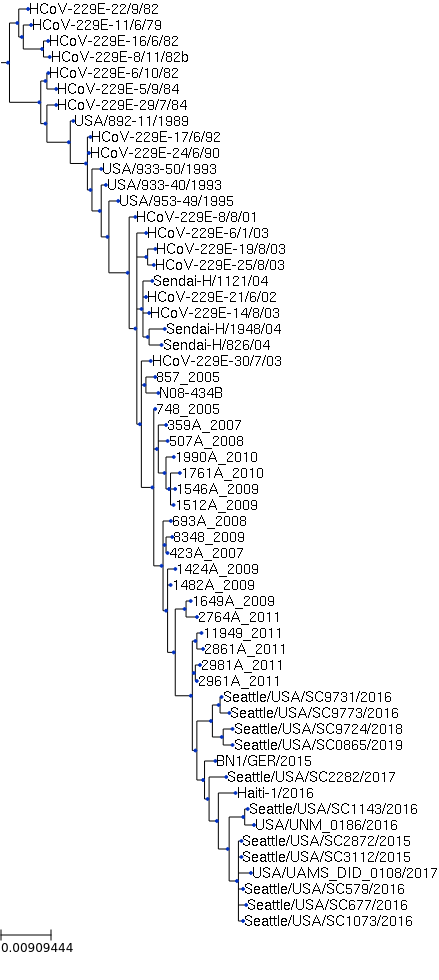

Reading tree from results/timetree/timetree.newick


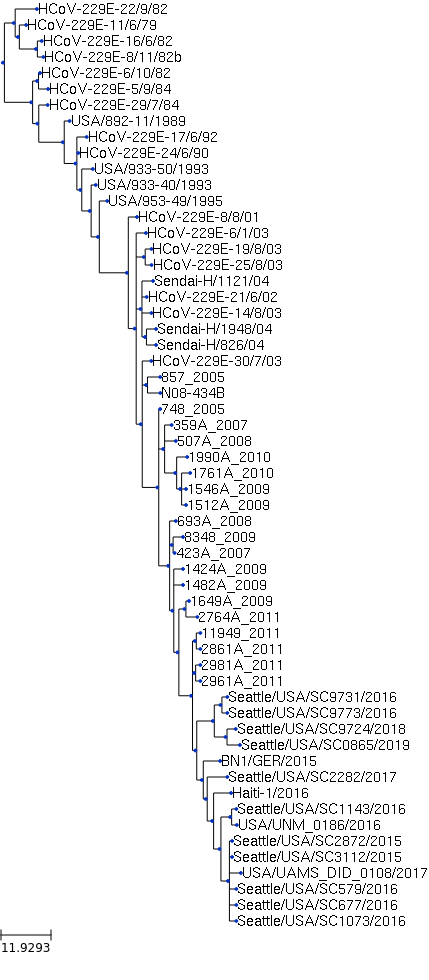

In [7]:
for branch_len in ['divergence', 'time']:
    treefile = config[f"{branch_len}tree"]
    print(f"Reading tree from {treefile}")
    t = ete3.Tree(treefile, format=1)
    
    ts = ete3.TreeStyle()
    ts.show_leaf_name = True  # show tip names
#    ts.scale = 10000  # pixels per branch-length unit
    
    display(t.render('%%inline', tree_style=ts))
#    break

In [4]:
ts = ete3.TreeStyle()
ts.show_leaf_name = True  # show tip names
ts.scale = 10000  # pixels per branch-length unit

t.render('%%inline', tree_style=ts)